风向加权后的水平扩散系数 $K_x$ 和 $K_y$ 是由主导风向角 $\theta$、侧风削弱系数 $\alpha$ 以及建筑增强函数 $F_{bld}(x, y)$ 共同决定的
$$
K_x(x, y) = K_0 \cdot F_{bld}(x, y)\cdot \left(\cos^2\theta + \alpha \sin^2\theta\right)
$$

$$
K_y(x, y) = K_0 \cdot F_{bld}(x, y)\cdot \left(\sin^2\theta + \alpha \cos^2\theta\right)
$$

$$F_{bld}(x, y) = 1 + \sum_{i=1}^{N} A_i \exp \left( -\frac{(x - x_i)^2 + (y - y_i)^2}{R_i^2} \right)$$

参数设置：
$A_i$ 见buildings参数；


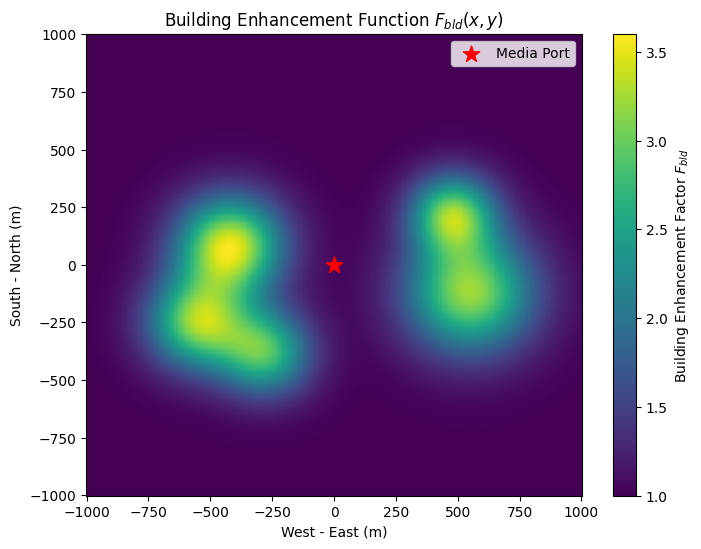

Max Kx: 12.60, Min Kx: 3.50
Max Ky: 16.21, Min Ky: 4.50


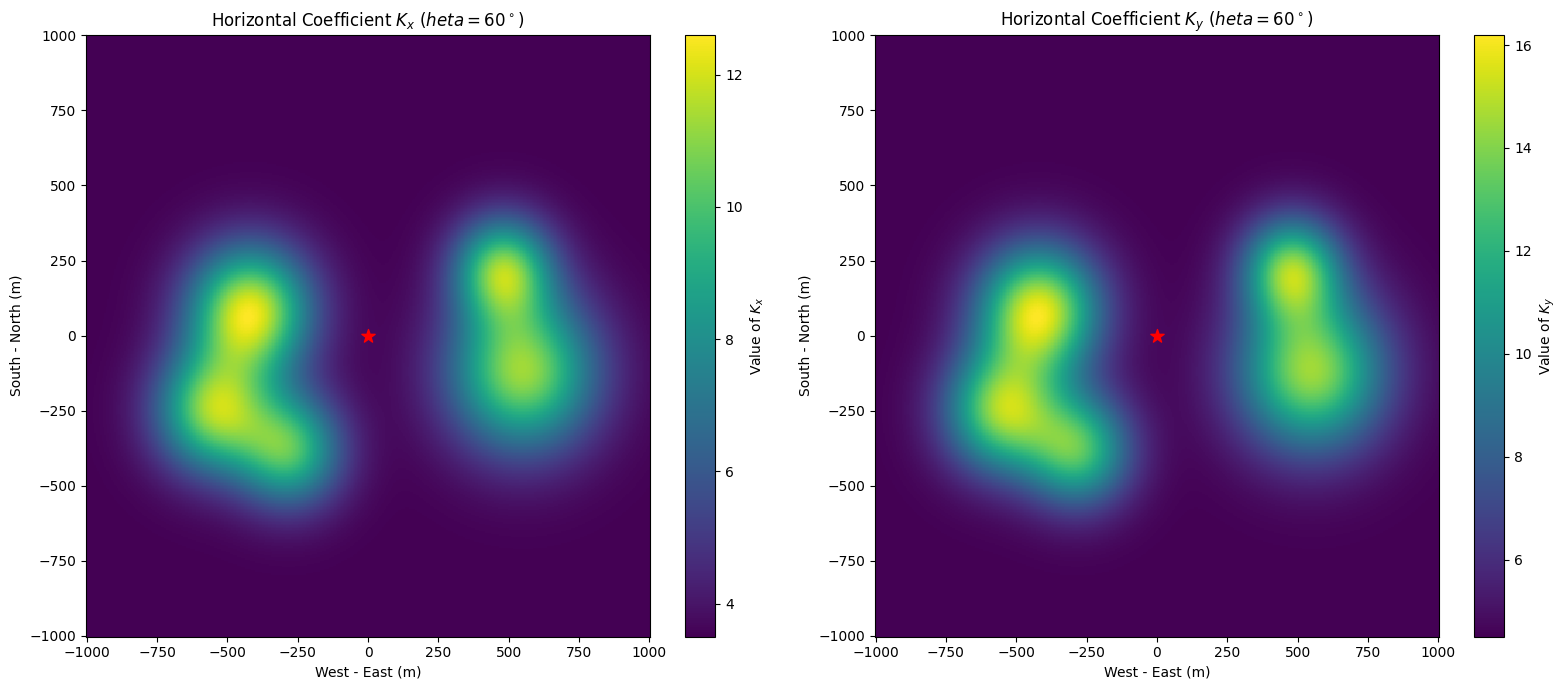

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 参数设定 ---
K0 = 5.0            # 背景水平扩散常数 (m^2/s)
theta_deg = 60      # 主导风向角 (60度表示东南风)
theta = np.deg2rad(theta_deg)
alpha = 0.6         # 侧风削弱系数 (模拟顺风向拉伸)

# 网格设置
res = 400
x = np.linspace(-1000, 1000, res)
y = np.linspace(-1000, 1000, res)
X, Y = np.meshgrid(x, y)

# --- 第一步：计算建筑增强函数 Fbld(x, y) ---
# (基于之前抽象的小区中心坐标 xi, yi, 强度 Ai, 影响半径 Ri)
buildings = [
    {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
    {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
    {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
    {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
    {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
]

Fbld = np.ones_like(X)
for b in buildings:
    dist_sq = (X - b['x'])**2 + (Y - b['y'])**2
    Fbld += b['A'] * np.exp(-dist_sq / (2 * b['R']**2))

# F的可视化—— 等高线
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Fbld, levels=50, cmap='viridis')
plt.colorbar(contour, label='Building Enhancement Factor $F_{bld}$')



# --- 第二步：求解风向加权后的 Kx 和 Ky ---
# 这一步实现了模型中对扩散各向异性的描述
Kx = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
Ky = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld

print(f"Max Kx: {np.max(Kx):.2f}, Min Kx: {np.min(Kx):.2f}")
print(f"Max Ky: {np.max(Ky):.2f}, Min Ky: {np.min(Ky):.2f}")

# 保存结果到csv文件
import pandas as pd
df = pd.DataFrame({
    'X': X.flatten(),
    'Y': Y.flatten(),
    'Kx': Kx.flatten(),
    'Ky': Ky.flatten(),
    'Fbld': Fbld.flatten()
})
df.to_csv('cul_K.csv', index=False)

# --- 结果可视化 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 绘制 Kx 分布图
im1 = ax1.pcolormesh(X, Y, Kx, shading='auto', cmap='viridis')
ax1.set_title(f'Horizontal Coefficient $K_x$ ($\theta={theta_deg}^\circ$)')
fig.colorbar(im1, ax=ax1, label='Value of $K_x$')

# 绘制 Ky 分布图
im2 = ax2.pcolormesh(X, Y, Ky, shading='auto', cmap='viridis')
ax2.set_title(f'Horizontal Coefficient $K_y$ ($\theta={theta_deg}^\circ$)')
fig.colorbar(im2, ax=ax2, label='Value of $K_y$')

for ax in [ax1, ax2]:
    ax.set_xlabel('West - East (m)')
    ax.set_ylabel('South - North (m)')
    ax.scatter(0, 0, c='red', marker='*', s=100) # 标注广州塔

plt.tight_layout()
plt.show()

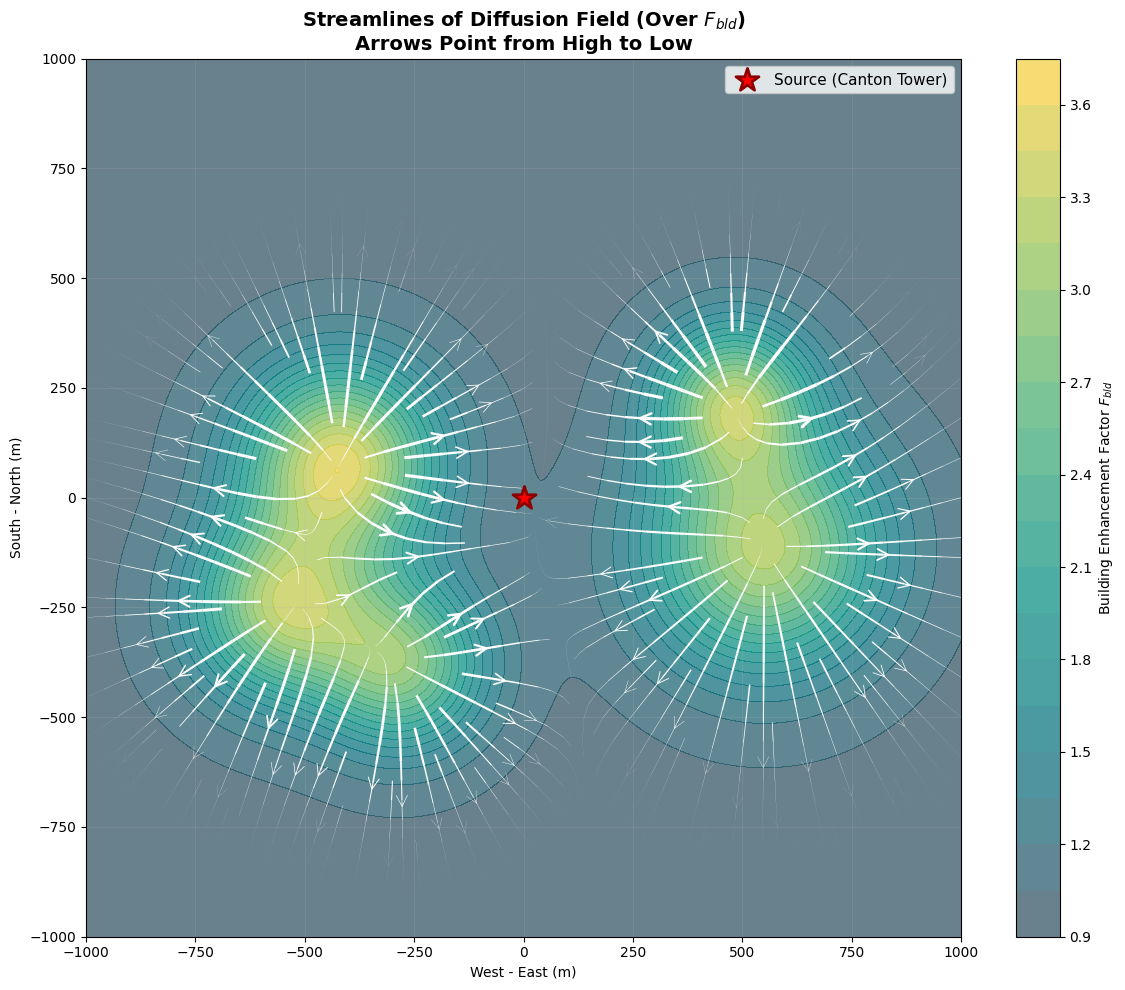

In [46]:
# ================= 6. 第3张图：扩散场流线图 =================
plt.figure(figsize=(12, 10))
plt.gcf().patch.set_facecolor('white')

# 以 Fbld 作为背景，使用填充等高线
contourf_bg = plt.contourf(X, Y, Fbld, levels=20, cmap=cmap_custom, alpha=0.7)

# 计算 Fbld 的梯度，使箭头指向从高处指向低处
grad_Fbld_x, grad_Fbld_y = np.gradient(Fbld, axis=(1, 0))

# 计算梯度的模，作为流线宽度
grad_magnitude = np.sqrt(grad_Fbld_x**2 + grad_Fbld_y**2)
grad_magnitude = np.where(grad_magnitude > 0, grad_magnitude, 1)  # 避免除以零

# 绘制流线，箭头指向从高处指向低处（梯度方向）
plt.streamplot(X, Y, -grad_Fbld_x, -grad_Fbld_y, color='white', density=1.5, 
               linewidth=grad_magnitude/grad_magnitude.max()*2.5, arrowsize=2, arrowstyle='->')

plt.title('Streamlines of Diffusion Field (Over $F_{bld}$)\nArrows Point from High to Low', 
          fontsize=14, fontweight='bold')
plt.xlabel('West - East (m)')
plt.ylabel('South - North (m)')
cbar_bg = plt.colorbar(contourf_bg, label='Building Enhancement Factor $F_{bld}$')
plt.scatter(0, 0, c='red', marker='*', s=300, label='Source (Canton Tower)', 
            zorder=5, edgecolors='darkred', linewidths=2)
plt.legend(fontsize=11, loc='upper right')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

$K_z(z) = K_{z\infty} (1 - e^{-z/h_0})$

地面 Kz(0): 0.0000
广州塔处 Kz(600): 2.0000


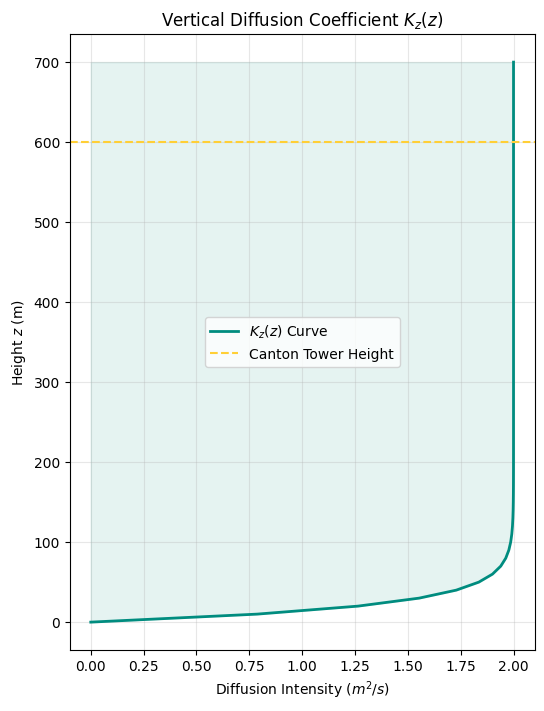

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- 参数设定 (基于您的模型建议) ---
Kz_inf = 2.0      # 远场（高空）垂直扩散强度
h0 = 20.0         # “抑制层”厚度特征值，通常取 10-30m
z_max = 700       # 最大高度 (覆盖广州塔600m)
dz = 10           # 垂直步长

# 1. 建立垂直网格
z_grid = np.arange(0, z_max + dz, dz)

# 2. 计算 Kz 向量
# 公式: Kz(z) = Kz_inf * (1 - exp(-z/h0))
Kz = Kz_inf * (1 - np.exp(-z_grid / h0))

# 3. 结果验证
print(f"地面 Kz(0): {Kz[0]:.4f}") # 验证是否符合 Kz(0)=0
print(f"广州塔处 Kz(600): {Kz[int(600/dz)]:.4f}")

# --- 可视化 ---
plt.figure(figsize=(6, 8))
plt.plot(Kz, z_grid, color='#008C7F', linewidth=2, label='$K_z(z)$ Curve')
plt.axhline(y=600, color='#FFCF36', linestyle='--', label='Canton Tower Height')
plt.fill_betweenx(z_grid, 0, Kz, color='#008C7F', alpha=0.1)

plt.title('Vertical Diffusion Coefficient $K_z(z)$', fontsize=12)
plt.xlabel('Diffusion Intensity ($m^2/s$)')
plt.ylabel('Height $z$ (m)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

对于每一个网格点 $(i, j, k)$，其浓度 $C$ 在时间步 $n+1$ 的值由下式决定：$$C_{i,j,k}^{n+1} = C_{i,j,k}^n + \Delta t \left[ \text{Diff}_x + \text{Diff}_y + \text{Diff}_z + S \right]$$其中，水平方向（以 $x$ 为例）的扩散项离散为：$$\text{Diff}_x \approx \frac{K_{x,i+1/2}(C_{i+1} - C_i) - K_{x,i-1/2}(C_i - C_{i-1})}{\Delta x^2}$$这种格式能够精确捕捉由于建筑物 $F_{bld}$ 导致的局部扩散系数跳变。

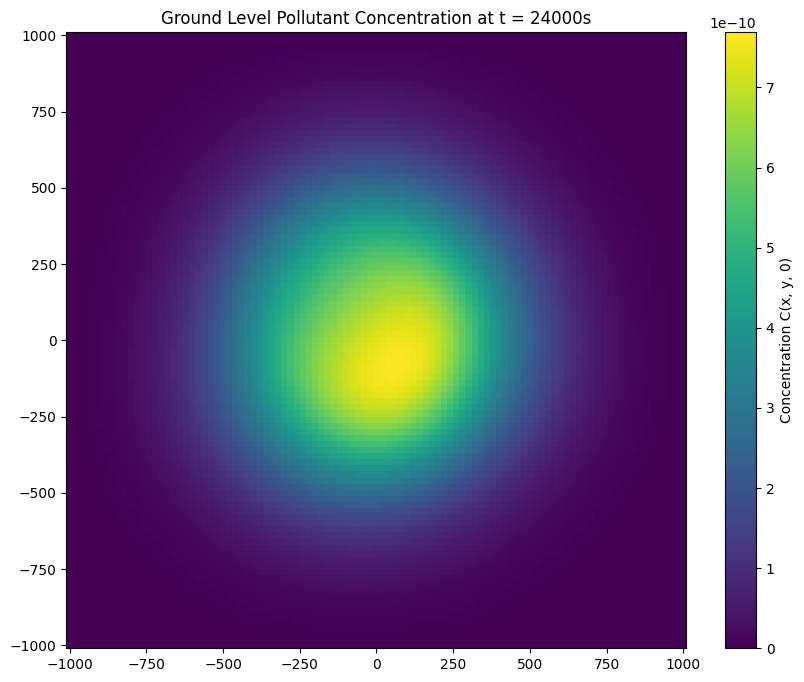

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# ================= 1. 网格与离散化参数 =================
dx, dy, dz = 50, 50, 30           # 空间步长 (m)
nx, ny, nz = 101, 101, 71         # 网格数 (2km x 2km x 700m)
dt = 10                          # 时间步长 (s)
total_time = 24000                  # 模拟时长 (400分钟)
steps = int(total_time / dt)

# 坐标向量
x_vec = np.linspace(-1000, 1000, nx)
y_vec = np.linspace(-1000, 1000, ny)
z_vec = np.linspace(0, 700, nz)
X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

# ================= 2. 物理系数初始化 =================

# (1) 建筑增强函数 Fbld
buildings = [
    {"x": -80, "y": 80,  "A": 5, "R": 150}, # 媒体港
    {"x": 480,  "y": 220, "A": 1, "R": 120}, # 珠江帝景北
    {"x": 550,  "y": -120, "A": 1, "R": 180}, # 珠江帝景东
    {"x": -280, "y": -380, "A": 1, "R": 130}, # 泊雅湾
    {"x": -550, "y": -250, "A": 1, "R": 140}  # 帝景华苑
]
Fbld = np.ones((nx, ny))
for b in buildings:
    Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

# (2) 水平扩散系数 Kx, Ky
K0, theta, alpha = 10.0, np.deg2rad(80), 0.8
Kx_2d = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
Ky_2d = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld

# (3) 垂直扩散系数 Kz
Kz_inf, h0 = 2.0, 20.0
Kz_vec = Kz_inf * (1 - np.exp(-z_vec / h0))

# 广播至 3D
Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
Kz = np.tile(Kz_vec, (nx, ny, 1))

# ================= 3. 初始条件 (瞬时脉冲) =================
C = np.zeros((nx, ny, nz))
M = 1e8 
zs_idx = np.argmin(np.abs(z_vec - 600)) # 广州塔 600m
C[nx//2, ny//2, zs_idx] = M / (dx * dy * dz)

# ================= 4. 数值迭代循环 =================
for s in range(steps):
    C_old = C.copy()
    
    # 有限差分离散化
    diff_x = np.zeros_like(C)
    diff_x[1:-1, :, :] = (Kx[1:-1, :, :] * (C_old[2:, :, :] - 2*C_old[1:-1, :, :] + C_old[:-2, :, :])) / dx**2
    
    diff_y = np.zeros_like(C)
    diff_y[:, 1:-1, :] = (Ky[:, 1:-1, :] * (C_old[:, 2:, :] - 2*C_old[:, 1:-1, :] + C_old[:, :-2, :])) / dy**2
    
    diff_z = np.zeros_like(C)
    diff_z[:, :, 1:-1] = (Kz[:, :, 1:-1] * (C_old[:, :, 2:] - 2*C_old[:, :, 1:-1] + C_old[:, :, :-2])) / dz**2
    
    C += dt * (diff_x + diff_y + diff_z)
    
    # 应用边界条件: dC/dz=0 at z=0
    C[:, :, 0] = C[:, :, 1]
    C[:, :, -1] = C[:, :, -2]

# ================= 5. 输出特定时刻地面浓度 =================
plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, C[:, :, 0], shading='auto', cmap='viridis')
plt.colorbar(label='Concentration C(x, y, 0)')
plt.title(f'Ground Level Pollutant Concentration at t = {total_time}s')
plt.show()

开始模拟，共 800 步...
进度: 0/800 (0.0%)
进度: 100/800 (12.5%)
进度: 200/800 (25.0%)
进度: 300/800 (37.5%)
进度: 400/800 (50.0%)
进度: 500/800 (62.5%)
进度: 600/800 (75.0%)
进度: 700/800 (87.5%)
模拟完成！
正在保存浓度结果...
地面浓度已保存至 concentration_ground.csv

地面浓度统计:
最大值: 8.39e+04
平均值: 1.16e+03
中位数: 6.69e-08
浓度分布区间:
0 - 1e-20: 1164 points
1e-20 - 1e-15: 1085 points
1e-15 - 1e-10: 1645 points
1e-10 - 1e-5: 2160 points
1e-5 - 1e-2: 1370 points
1e-2 - 1: 914 points
1 - 1e2: 848 points
>= 1e2: 1015 points


开始模拟，共 800 步...
进度: 0/800 (0.0%)
进度: 100/800 (12.5%)
进度: 200/800 (25.0%)
进度: 300/800 (37.5%)
进度: 400/800 (50.0%)
进度: 500/800 (62.5%)
进度: 600/800 (75.0%)
进度: 700/800 (87.5%)
模拟完成！
正在保存浓度结果...
地面浓度已保存至 concentration_ground.csv

地面浓度统计:
最大值: 8.39e+04
平均值: 1.16e+03
中位数: 6.69e-08
浓度分布区间:
0 - 1e-20: 1164 points
1e-20 - 1e-15: 1085 points
1e-15 - 1e-10: 1645 points
1e-10 - 1e-5: 2160 points
1e-5 - 1e-2: 1370 points
1e-2 - 1: 914 points
1 - 1e2: 848 points
>= 1e2: 1015 points


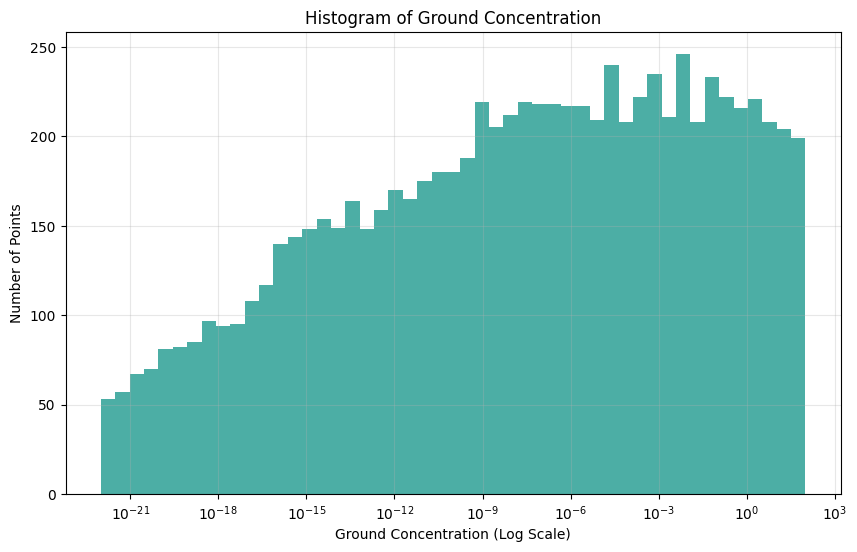

开始模拟，共 800 步...
进度: 0/800 (0.0%)
进度: 100/800 (12.5%)
进度: 200/800 (25.0%)
进度: 300/800 (37.5%)
进度: 400/800 (50.0%)
进度: 500/800 (62.5%)
进度: 600/800 (75.0%)
进度: 700/800 (87.5%)
模拟完成！
正在保存浓度结果...
地面浓度已保存至 concentration_ground.csv

地面浓度统计:
最大值: 8.39e+04
平均值: 1.16e+03
中位数: 6.69e-08
浓度分布区间:
0 - 1e-20: 1164 points
1e-20 - 1e-15: 1085 points
1e-15 - 1e-10: 1645 points
1e-10 - 1e-5: 2160 points
1e-5 - 1e-2: 1370 points
1e-2 - 1: 914 points
1 - 1e2: 848 points
>= 1e2: 1015 points


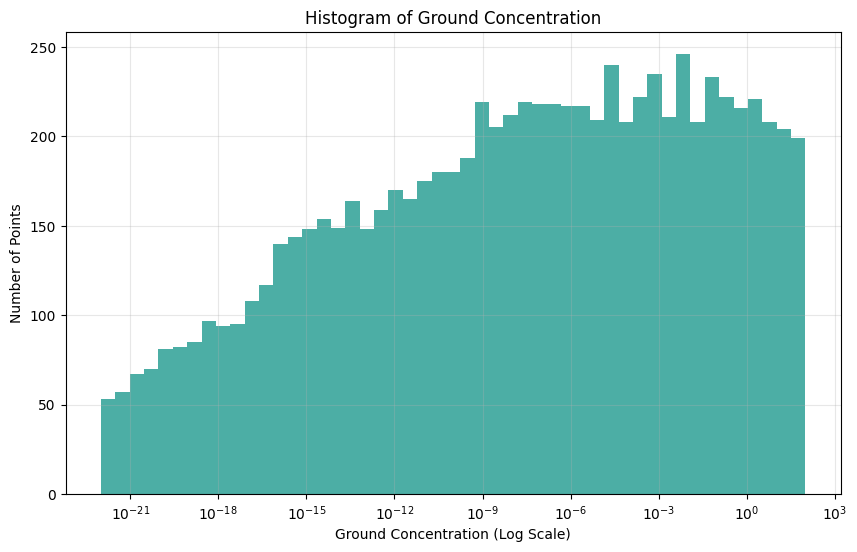

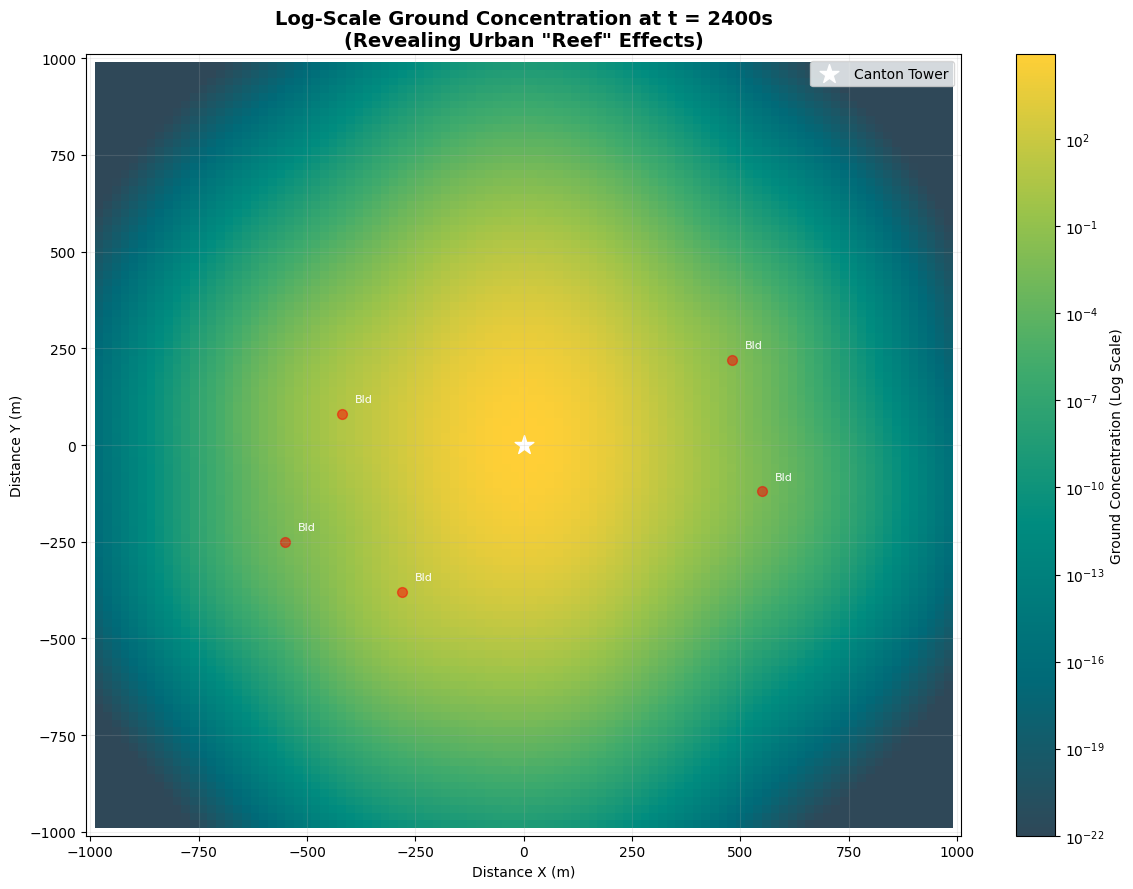


地面浓度统计:
最大值: 8.39e+04
平均值: 1.16e+03
中位数: 6.69e-08


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, LogNorm

# ================= 1. 网格与配色初始化 =================
color_list = ["#FFCF36", "#9BC34A", "#40AB6C", "#008C7F", "#006A78", "#2F4858"]
cmap_custom = LinearSegmentedColormap.from_list("custom", color_list[::-1])

dx, dy, dz = 20, 20, 10           # 提高分辨率
nx, ny, nz = 101, 101, 71
dt = 3                         # 减小步长确保数值稳定
total_time = 2400                 # 延长至 4000秒 (约40分钟)
steps = int(total_time / dt)                 # 15分钟


x_vec = np.linspace(-1000, 1000, nx)
y_vec = np.linspace(-1000, 1000, ny)
z_vec = np.linspace(0, 700, nz)
X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

# ================= 2. 物理场构建 =================
# 建筑增强
buildings = [
    {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
    {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
    {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
    {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
    {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
]
Fbld = np.ones((nx, ny))
for b in buildings:
    Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

# 各向异性扩散系数
K0, theta, alpha = 3.0, np.deg2rad(80), 0.4 
Kx_2d = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
Ky_2d = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld

# 垂直扩散
Kz_vec = 2.0 * (1 - np.exp(-z_vec / 20.0))
Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
Kz = np.tile(Kz_vec, (nx, ny, 1))

# ================= 3. 瞬时脉冲释放与迭代 =================
C = np.zeros((nx, ny, nz))
M = 1e20 
C[nx//2, ny//2, int(600/dz)] = M / (dx*dy*dz) # 广州塔 600m

print(f"开始模拟，共 {steps} 步...")
for s in range(steps):
    if s % 100 == 0:
        print(f"进度: {s}/{steps} ({100*s/steps:.1f}%)")
    
    C_old = C.copy()
    # 三维变系数扩散离散化
    C[1:-1, 1:-1, 1:-1] += dt * (
        (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2 +
        (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2 +
        (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2
    )
    # 边界条件
    C[:, :, 0] = C[:, :, 1]   # 地面不穿透
    C[:, :, -1] = C[:, :, -2]

print("模拟完成！")

# ================= 4. 保存浓度结果到CSV文件 =================
print("正在保存浓度结果...")
# 保存地面层浓度
df_ground = pd.DataFrame({
    'X': X.flatten(),
    'Y': Y.flatten(),
    'Concentration_Ground': C[:, :, 1].flatten()
})
df_ground.to_csv('concentration_ground.csv', index=False)
print(f"地面浓度已保存至 concentration_ground.csv")

# 如果需要保存完整3D浓度场（可选）
# 注意：完整3D数据量较大，可能生成几百MB的文件
# save_full_3d = False  # 设置为True以保存完整3D数据
# if save_full_3d:
#     X_3d, Y_3d, Z_3d = np.meshgrid(x_vec, y_vec, z_vec, indexing='ij')
#     df_3d = pd.DataFrame({
#         'X': X_3d.flatten(),
#         'Y': Y_3d.flatten(),
#         'Z': Z_3d.flatten(),
#         'Concentration': C.flatten()
#     })
#     df_3d.to_csv('concentration_3d_full.csv', index=False)
#     print(f"完整3D浓度已保存至 concentration_3d_full.csv")

# 对浓度数据进行统计
print(f"\n地面浓度统计:")
print(f"最大值: {C[:, :, 1].max():.2e}")
print(f"平均值: {C[:, :, 1].mean():.2e}")
print(f"中位数: {np.median(C[:, :, 1]):.2e}")
# 浓度数据的区间分布
print("浓度分布区间:")
print(f"0 - 1e-20: {(C[:, :, 1] < 1e-20).sum()} points")
print(f"1e-20 - 1e-15: {((C[:, :, 1] >= 1e-20) & (C[:, :, 1] < 1e-15)).sum()} points")
print(f"1e-15 - 1e-10: {((C[:, :, 1] >= 1e-15) & (C[:, :, 1] < 1e-10)).sum()} points")
print(f"1e-10 - 1e-5: {((C[:, :, 1] >= 1e-10) & (C[:, :, 1] < 1e-5)).sum()} points")
print(f"1e-5 - 1e-2: {((C[:, :, 1] >= 1e-5) & (C[:, :, 1] < 1e-2)).sum()} points")
print(f"1e-2 - 1: {((C[:, :, 1] >= 1e-2) & (C[:, :, 1] < 1)).sum()} points")
print(f"1 - 1e2: {((C[:, :, 1] >= 1) & (C[:, :, 1] < 1e2)).sum()} points")
print(f">= 1e2: {(C[:, :, 1] >= 1e2 ).sum()} points")
# 绘制浓度分布的直方图
plt.figure(figsize=(10, 6))
plt.hist(C[:, :, 1].flatten(), bins=np.logspace(-22, 2, 50), color='#008C7F', alpha=0.7)
plt.xscale('log')
plt.xlabel('Ground Concentration (Log Scale)')
plt.ylabel('Number of Points')
plt.title('Histogram of Ground Concentration')
plt.grid(alpha=0.3)
plt.show()
# ================= 5. 对数尺度绘图 =================
plt.figure(figsize=(12, 9))
plt.gcf().patch.set_facecolor('white')

# 使用 LogNorm 对数色标，捕捉 7 个数量级以上的浓度变化
pcm = plt.pcolormesh(X, Y, C[:, :, 1], 
                     norm=LogNorm(vmin=1e-22, vmax=C[:, :, 1].max() + 1e-25), 
                     shading='auto', 
                     cmap=cmap_custom)

plt.colorbar(pcm, label='Ground Concentration (Log Scale)')

# 标注广州塔和建筑位置
plt.scatter(0, 0, marker='*', color='white', s=200, label='Canton Tower')
for b in buildings:
    plt.scatter(b['x'], b['y'], marker='o', color='red', s=50, alpha=0.5)
    plt.text(b['x']+30, b['y']+30, "Bld", color='white', fontsize=8)

plt.title(f'Log-Scale Ground Concentration at t = {total_time}s\n(Revealing Urban "Reef" Effects)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Distance X (m)')
plt.ylabel('Distance Y (m)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 输出统计信息
print(f"\n地面浓度统计:")
print(f"最大值: {C[:, :, 0].max():.2e}")
print(f"平均值: {C[:, :, 0].mean():.2e}")
print(f"中位数: {np.median(C[:, :, 0]):.2e}")

In [ ]:
# 调用示例 (需配合您之前的 C 矩阵)
# 使用注释，因为 X_3d, Y_3d, Z_3d, buildings_data 需要在前面的单元格中定义
# 如果需要使用此函数，请取消下面的注释并确保上述变量已定义
# draw_3d_smoke_plot(X_3d, Y_3d, Z_3d, C, buildings_data)

# 正确的调用方式示例：
# 首先在前面单元格中添加：
# X_3d, Y_3d, Z_3d = np.meshgrid(x_vec, y_vec, z_vec, indexing='ij')
# buildings_data = [{"name": "Building1", "x": 100, "y": 100, "z": 100}, ...]
# 然后调用：
# draw_3d_smoke_plot(X_3d, Y_3d, Z_3d, C, buildings_data)

NameError: name 'X_3d' is not defined


各小区平均浓度:
Media Port (媒体港): 2.16e+01
PR North (珠江帝景北): 4.57e-02
PR East (珠江帝景东): 1.02e-02
Boyawan (泊雅湾/利安): 5.51e+01
Dijing Huayuan (帝景华苑): 8.67e-03



各小区平均浓度:
Media Port (媒体港): 2.16e+01
PR North (珠江帝景北): 4.57e-02
PR East (珠江帝景东): 1.02e-02
Boyawan (泊雅湾/利安): 5.51e+01
Dijing Huayuan (帝景华苑): 8.67e-03


C:\Users\15706\AppData\Local\Temp\ipykernel_7516\2199921709.py:44: UserWarning: Glyph 23186 (\N{CJK UNIFIED IDEOGRAPH-5A92}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_7516\2199921709.py:44: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_7516\2199921709.py:44: UserWarning: Glyph 28207 (\N{CJK UNIFIED IDEOGRAPH-6E2F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_7516\2199921709.py:44: UserWarning: Glyph 29664 (\N{CJK UNIFIED IDEOGRAPH-73E0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_7516\2199921709.py:44: UserWarning: Glyph 27743 (\N{CJK UNIFIED IDEOGRAPH-6C5F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\15706\AppData\Local\Temp\ipykernel_7516\2199921709.py:44: UserWarning: Glyph 24093 (\N{CJK 

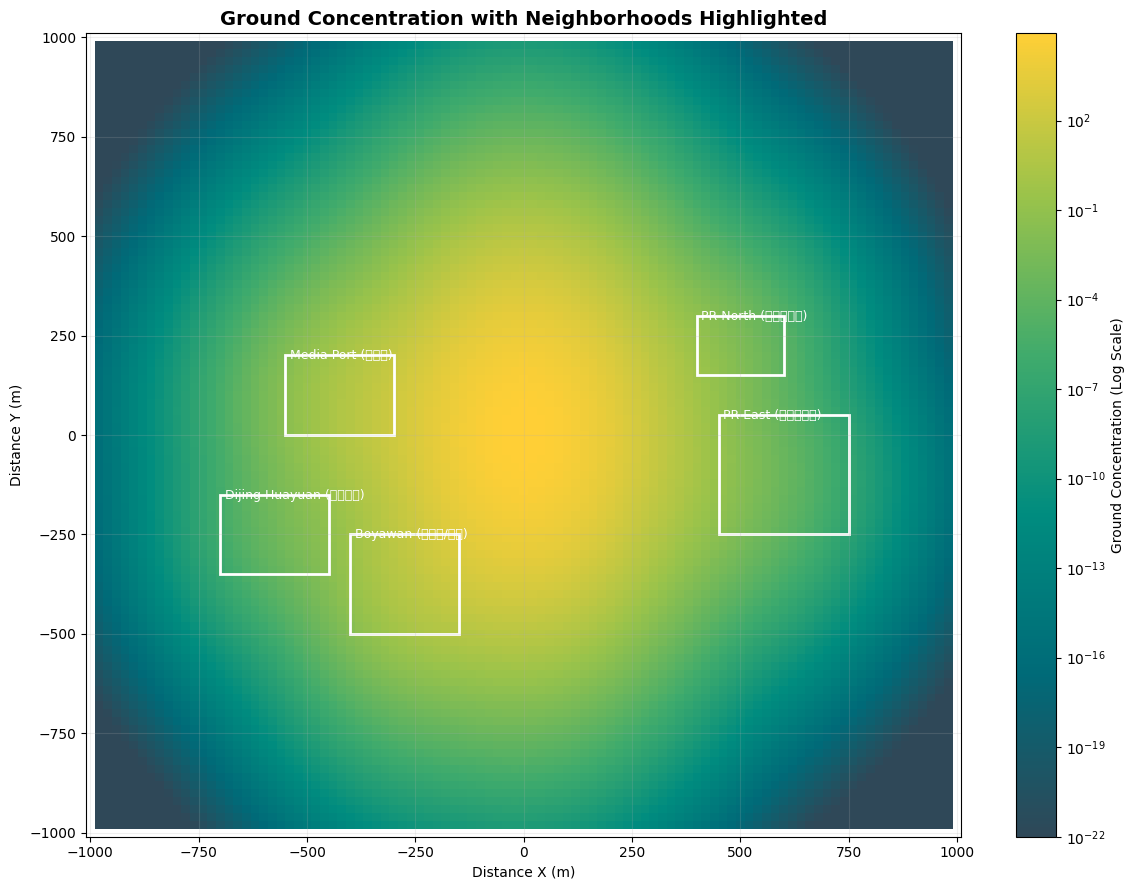

In [6]:
# 定义小区字典：名称, X范围 [min, max], Y范围 [min, max]
neighborhoods = {
    "Media Port (媒体港)": {"x": [-550, -300], "y": [0, 200]},
    "PR North (珠江帝景北)": {"x": [400, 600], "y": [150, 300]},
    "PR East (珠江帝景东)": {"x": [450, 750], "y": [-250, 50]},
    "Boyawan (泊雅湾/利安)": {"x": [-400, -150], "y": [-500, -250]},
    "Dijing Huayuan (帝景华苑)": {"x": [-700, -450], "y": [-350, -150]}
}
# 计算每个小区的平均浓度
print("\n各小区平均浓度:")
for name, bounds in neighborhoods.items():
    x_min, x_max = bounds['x']
    y_min, y_max = bounds['y']
    
    # 找到对应的网格索引
    x_indices = np.where((x_vec >= x_min) & (x_vec <= x_max))[0]
    y_indices = np.where((y_vec >= y_min) & (y_vec <= y_max))[0]
    
    # 提取小区内的浓度数据
    neighborhood_concentration = C[np.ix_(x_indices, y_indices, [0])].flatten()
    
    # 计算平均浓度
    avg_concentration = neighborhood_concentration.mean()
    
    print(f"{name}: {avg_concentration:.2e}")

# 可视化小区的空间位置和浓度分布
plt.figure(figsize=(12, 9))
pcm = plt.pcolormesh(X, Y, C[:, :, 0],  
                     norm=LogNorm(vmin=1e-22, vmax=C[:, :, 0].max() + 1e-25), 
                     shading='auto', 
                     cmap=cmap_custom)
plt.colorbar(pcm, label='Ground Concentration (Log Scale)')
for name, bounds in neighborhoods.items():
    x_min, x_max = bounds['x']
    y_min, y_max = bounds['y']
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                      edgecolor='white', facecolor='none', lw=2))
    plt.text(x_min + 10, y_max - 10, name, color='white', fontsize=9)
plt.title(f'Ground Concentration with Neighborhoods Highlighted', fontsize=14, fontweight='bold')
plt.xlabel('Distance X (m)')
plt.ylabel('Distance Y (m)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

开始时间序列模拟...
进度: 0.0%
进度: 8.3%
进度: 16.7%
进度: 25.0%
进度: 33.3%
进度: 41.7%
进度: 50.0%
进度: 58.3%
进度: 66.7%
进度: 75.0%
进度: 83.3%
进度: 91.7%


开始时间序列模拟...
进度: 0.0%
进度: 8.3%
进度: 16.7%
进度: 25.0%
进度: 33.3%
进度: 41.7%
进度: 50.0%
进度: 58.3%
进度: 66.7%
进度: 75.0%
进度: 83.3%
进度: 91.7%


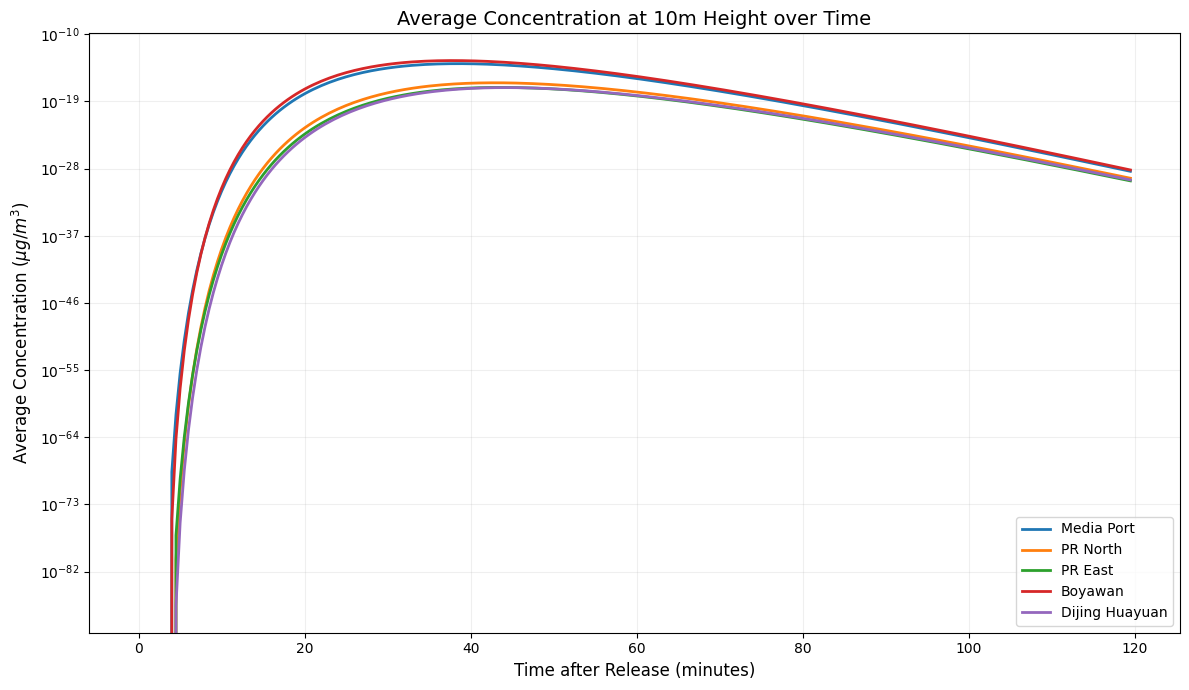

小区时间序列数据已保存。


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# ================= 1. 物理参数与网格初始化 =================
color_list = ["#FFCF36", "#9BC34A", "#40AB6C", "#008C7F", "#006A78", "#2F4858"]
cmap_custom = LinearSegmentedColormap.from_list("custom", color_list[::-1])

dx, dy, dz = 20, 20, 10
nx, ny, nz = 101, 101, 71
dt = 3.0    # 30s  
total_time = 7200  # 延长模拟至 1 小时，观察浓度上升全过程
steps = int(total_time / dt)    #1200 步

x_vec = np.linspace(-1000, 1000, nx)
y_vec = np.linspace(-1000, 1000, ny)
z_vec = np.linspace(0, 700, nz)
X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

# ================= 2. 物理场构建与小区定义 =================
buildings_cfg = [
    {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
    {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
    {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
    {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
    {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
]

# 定义各小区计算边界
neighborhoods = {
    "Media Port": {"x": [-550, -300], "y": [0, 200]},
    "PR North": {"x": [400, 600], "y": [150, 300]},
    "PR East": {"x": [450, 750], "y": [-250, 50]},
    "Boyawan": {"x": [-400, -150], "y": [-500, -250]},
    "Dijing Huayuan": {"x": [-700, -450], "y": [-350, -150]}
}

Fbld = np.ones((nx, ny))
for b in buildings_cfg:
    Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

# 各向异性扩散与垂直梯度
K0, theta, alpha = 3.0, np.deg2rad(80), 0.4 
Kx_2d = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
Ky_2d = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld
Kz_vec = 2.0 * (1 - np.exp(-z_vec / 20.0))

Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
Kz = np.tile(Kz_vec, (nx, ny, 1))

# ================= 3. 时间序列模拟循环 =================
C = np.zeros((nx, ny, nz))
M = 1e15  # 调整为更合理的释放量以方便观察
C[nx//2, ny//2, int(600/dz)] = M / (dx*dy*dz) 

# 用于存储结果的字典
history = {name: [] for name in neighborhoods.keys()}
time_axis = []

print(f"开始时间序列模拟...")
for s in range(steps):
    C_old = C.copy()
    
    # --- 核心模型：三维扩散 + 线性衰减 (-0.01*C) ---

    # 1. 计算三维扩散项 (二阶中心差分)
    term_x = (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2
    term_y = (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2
    term_z = (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2

    # 2. 定义衰减系数 (λ = 0.01)
    lambda_decay = 0.01

    # 3. 更新浓度 C
    # 括号内包含了：扩散(Diffusion) - 衰减(Decay)
    C[1:-1, 1:-1, 1:-1] += dt * (term_x + term_y + term_z - lambda_decay * C_old[1:-1, 1:-1, 1:-1])
        
    # 边界条件：地面反射
    C[:, :, 0] = C[:, :, 1]
    C[:, :, -1] = C[:, :, -2]

    # 每隔 10 个时间步记录一次小区平均浓度 (减少计算开销)
    if s % 10 == 0:
        current_time = s * dt
        time_axis.append(current_time / 60.0) # 转为分钟
        
        for name, bounds in neighborhoods.items():
            # 空间索引掩码提取
            mask = (X >= bounds["x"][0]) & (X <= bounds["x"][1]) & \
                   (Y >= bounds["y"][0]) & (Y <= bounds["y"][1])
            # 计算 10m 高度 (index 1) 的平均浓度
            avg_c = np.mean(C[:, :, 1][mask])
            history[name].append(avg_c)
            
    if s % 200 == 0:
        print(f"进度: {s/steps*100:.1f}%")

# ================= 4. 绘制时间序列结果图 =================
plt.figure(figsize=(12, 7))
for name in history:
    plt.plot(time_axis, history[name], label=name, linewidth=2)

plt.yscale('log') # 浓度变化大，建议用对数坐标
plt.title("Average Concentration at 10m Height over Time", fontsize=14)
plt.xlabel("Time after Release (minutes)", fontsize=12)
plt.ylabel("Average Concentration ($\mu g/m^3$)", fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# ================= 5. 数据导出 =================
df_history = pd.DataFrame(history)
df_history.insert(0, 'Time_min', time_axis)
df_history.to_csv('neighborhood_time_series.csv', index=False)
print("小区时间序列数据已保存。")

可视化瞬时脉冲函数

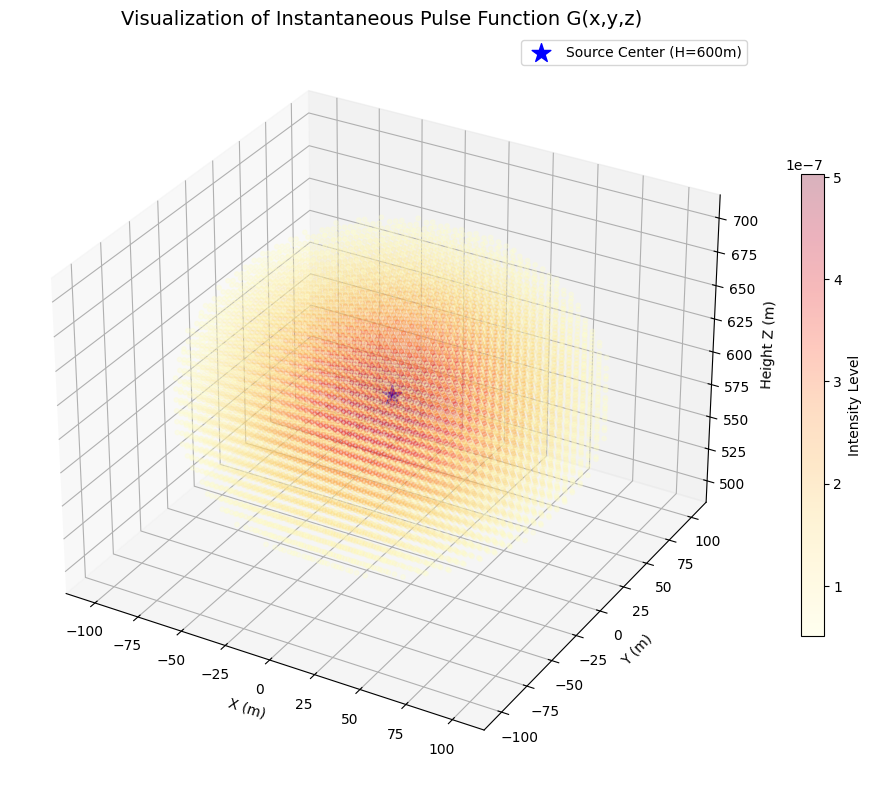

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ================= 1. 函数定义 (基于 image_365805.png) =================
def gaussian_pulse(x, y, z, xs=0, ys=0, H=600, sigma=50):
    # 简化版三维高斯公式，假设各向同性 sigma_x = sigma_y = sigma_z
    prefactor = 1 / ((2 * np.pi)**(1.5) * sigma**3)
    exponent = -( ((x - xs)**2 / (2 * sigma**2)) + 
                  ((y - ys)**2 / (2 * sigma**2)) + 
                  ((z - H)**2 / (2 * sigma**2)) )
    return prefactor * np.exp(exponent)

# ================= 2. 空间网格采样 =================
res = 50
x = np.linspace(-200, 200, res)
y = np.linspace(-200, 200, res)
z = np.linspace(400, 800, res)
X, Y, Z = np.meshgrid(x, y, z)

# 计算函数值 G(x, y, z)
G = gaussian_pulse(X, Y, Z)

# ================= 3. 3D 可视化 =================
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 使用散点模拟体密度，颜色代表浓度强度
# 仅绘制强度大于阈值的点，以显示烟团核心
mask = G > (G.max() * 0.1)
scatter = ax.scatter(X[mask], Y[mask], Z[mask], c=G[mask], 
                     cmap='YlOrRd', s=10, alpha=0.3)

# 标注释放中心 (0, 0, 600)
ax.scatter(0, 0, 600, color='blue', marker='*', s=200, label='Source Center (H=600m)')

ax.set_title('Visualization of Instantaneous Pulse Function G(x,y,z)', fontsize=14)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Height Z (m)')
plt.colorbar(scatter, label='Intensity Level', shrink=0.6)
plt.legend()
plt.show()